# Problem Statement

Current benchmarks like SWE-bench and SWE-bench Verified evaluate agents on a diverse set of real-world engineering tasks. However, they lack any structured representation of the task space itself. As a result, these headline benchmarks function more as scoreboards than as frameworks for systematically guiding agent development. Without insight into how tasks are distributed or how they span the feature space, it becomes difficult to diagnose where and why agents succeed or fail — limiting the benchmark's utility for capability-driven progress.

# Research Question

Can we map the feature space of benchmark tasks using clustering techniques for mixed-type data, in order to better understand agent successes and failures? Can this structure then be used to both guide the development of specific agent capabilities and more accurately measure agent performance?

# Supported Sections: Results Unified Spherical Clustering
This notebook supports Unified Spherical Clustering results in the Results section.

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer
from sklearn.metrics import normalized_mutual_info_score


# Analysing the Annotation Dataset

In [ ]:
df_annotate = pd.read_csv("ensembled_annotations_public.csv")


In [ ]:
df_annotate.head()

,instance_id,underspecified,underspecified_notes,false_negative,false_negative_notes,other_major_issues,other_notes,difficulty,underspecified_decided_by,false_negative_decided_by,other_major_issues_decided_by,difficulty_decided_by,difficulty_ensemble_decision_procedure,filter_out
0,astropy__astropy-11693,1.0,The issue arises when attempting to plot an im...,3.0,"The test patch, checks that NoConvergence erro...",0.0,NaN,15 min - 1 hour,17,72,17,"[17, 72, 69]",majority,True
1,astropy__astropy-12544,0.0,The problem described in the issue is that whe...,3.0,"The parameter introduced is `mask_invalid`, wh...",0.0,NaN,1-4 hours,65,65,65,"[65, 71]",majority,True
2,astropy__astropy-12825,1.0,The issue is clear and steps to replicate it a...,2.0,The tests cover all solutions for both the sup...,0.0,NaN,1-4 hours,91,91,55,[12],median,True
3,astropy__astropy-12842,1.0,"Though, there are some external links were pro...",2.0,The tests are working but some perfectly reaso...,0.0,NaN,1-4 hours,87,87,87,"[90, 31]",majority,True
4,astropy__astropy-12880,1.0,"After upgrading from Astropy 4.2.1 to 5.0+, `B...",3.0,The test assumes a solution that involves allo...,0.0,NaN,<15 min fix,17,78,17,"[17, 78]",majority,True


# SWE-Bench Verified Dataset

In [ ]:
##dataset downloaded from huggingface

df=pd.read_csv("swe_bench_verified_test.csv")
df_merged = df.merge(df_annotate, on='instance_id', how='left')

In [ ]:
df_merged.head()

,repo,instance_id,base_commit,patch,test_patch,problem_statement,hints_text,created_at,version,FAIL_TO_PASS,...,false_negative_notes,other_major_issues,other_notes,difficulty_y,underspecified_decided_by,false_negative_decided_by,other_major_issues_decided_by,difficulty_decided_by,difficulty_ensemble_decision_procedure,filter_out
0,astropy/astropy,astropy__astropy-12907,d16bfe05a744909de4b27f5875fe0d4ed41ce607,diff --git a/astropy/modeling/separable.py b/a...,diff --git a/astropy/modeling/tests/test_separ...,Modeling's `separability_matrix` does not comp...,NaN,2022-03-03T15:14:54Z,4.3,"[""astropy/modeling/tests/test_separable.py::te...",...,The goal of the test patch is to evaluate nest...,0.0,NaN,15 min - 1 hour,75,75,75,"[75, 28]",majority,False
1,astropy/astropy,astropy__astropy-13033,298ccb478e6bf092953bca67a3d29dc6c35f6752,diff --git a/astropy/timeseries/core.py b/astr...,diff --git a/astropy/timeseries/tests/test_sam...,TimeSeries: misleading exception when required...,The relevant code that produces the misleading...,2022-03-31T23:28:27Z,4.3,"[""astropy/timeseries/tests/test_sampled.py::te...",...,The error message is raised is particular to t...,0.0,NaN,15 min - 1 hour,61,61,13,"[13, 17]",majority,False
2,astropy/astropy,astropy__astropy-13236,6ed769d58d89380ebaa1ef52b300691eefda8928,diff --git a/astropy/table/table.py b/astropy/...,diff --git a/astropy/table/tests/test_mixin.py...,Consider removing auto-transform of structured...,@mhvk - I'm happy to do this PR if you think i...,2022-05-09T14:16:30Z,5.0,"[""astropy/table/tests/test_mixin.py::test_ndar...",...,1. Issue description wants the agent to remove...,0.0,NaN,15 min - 1 hour,71,71,71,[71],median,False
3,astropy/astropy,astropy__astropy-13398,6500928dc0e57be8f06d1162eacc3ba5e2eff692,diff --git a/astropy/coordinates/builtin_frame...,diff --git a/astropy/coordinates/tests/test_in...,A direct approach to ITRS to Observed transfor...,"cc @StuartLittlefair, @adrn, @eteq, @eerovaher...",2022-06-24T15:22:11Z,5.0,"[""astropy/coordinates/tests/test_intermediate_...",...,The tests are well scoped and cover all possib...,0.0,NaN,1-4 hours,12,12,12,"[12, 62]",majority,False
4,astropy/astropy,astropy__astropy-13453,19cc80471739bcb67b7e8099246b391c355023ee,diff --git a/astropy/io/ascii/html.py b/astrop...,diff --git a/astropy/io/ascii/tests/test_html....,ASCII table output to HTML does not support su...,Welcome to Astropy 👋 and thank you for your fi...,2022-07-14T10:04:40Z,5.0,"[""astropy/io/ascii/tests/test_html.py::test_wr...",...,The `test_write_table_formatted_columns` funct...,0.0,NaN,15 min - 1 hour,67,67,67,"[61, 28]",majority,False


In [ ]:
#dropping duplicate columns and columns that provide the index number of people who made a given decision
cols_to_drop = ["difficulty_y"] + [col for col in df_merged.columns if col.endswith('_decided_by')] + \
              ["filter_out"] + ["difficulty_ensemble_decision_procedure"] + \
               ["other_notes"] +["other_major_issues"] + ["instance_id"] +["created_at"]+["version"] + \
               ["environment_setup_commit"] + ["base_commit"] +["test_patch"]
df_cleaned = df_merged.drop(columns = cols_to_drop)
df_cleaned = df_cleaned.rename(columns = {"difficulty_x":"difficulty"})

In [ ]:
df_cleaned.head()

,repo,patch,problem_statement,hints_text,FAIL_TO_PASS,PASS_TO_PASS,difficulty,underspecified,underspecified_notes,false_negative,false_negative_notes
0,astropy/astropy,diff --git a/astropy/modeling/separable.py b/a...,Modeling's `separability_matrix` does not comp...,NaN,"[""astropy/modeling/tests/test_separable.py::te...","[""astropy/modeling/tests/test_separable.py::te...",15 min - 1 hour,1.0,"The issue description is clear, explaining tha...",0.0,The goal of the test patch is to evaluate nest...
1,astropy/astropy,diff --git a/astropy/timeseries/core.py b/astr...,TimeSeries: misleading exception when required...,The relevant code that produces the misleading...,"[""astropy/timeseries/tests/test_sampled.py::te...","[""astropy/timeseries/tests/test_sampled.py::te...",15 min - 1 hour,1.0,The issue's concern is well understood. The va...,1.0,The error message is raised is particular to t...
2,astropy/astropy,diff --git a/astropy/table/table.py b/astropy/...,Consider removing auto-transform of structured...,@mhvk - I'm happy to do this PR if you think i...,"[""astropy/table/tests/test_mixin.py::test_ndar...","[""astropy/table/tests/test_mixin.py::test_attr...",15 min - 1 hour,1.0,1. It is clearly suggested that automatic conv...,0.0,1. Issue description wants the agent to remove...
3,astropy/astropy,diff --git a/astropy/coordinates/builtin_frame...,A direct approach to ITRS to Observed transfor...,"cc @StuartLittlefair, @adrn, @eteq, @eerovaher...","[""astropy/coordinates/tests/test_intermediate_...","[""astropy/coordinates/tests/test_intermediate_...",1-4 hours,0.0,Issue description is well specified. It inform...,0.0,The tests are well scoped and cover all possib...
4,astropy/astropy,diff --git a/astropy/io/ascii/html.py b/astrop...,ASCII table output to HTML does not support su...,Welcome to Astropy 👋 and thank you for your fi...,"[""astropy/io/ascii/tests/test_html.py::test_wr...","[""astropy/io/ascii/tests/test_html.py::test_li...",15 min - 1 hour,0.0,The issue description is very clear and well-o...,0.0,The `test_write_table_formatted_columns` funct...


# Feature Extraction From Patches

To prepare the dataset for clustering, I will extract the structural features from each task's associated pull request using the PatchSet class from the unidiff Python library.

A patch here refers to a code change and is also commonly referred to as a  diff — the code changes proposed to solve the benchmark task. PatchSet parses the unified diff format and allows for the extraction of a number of low-level structural signals from each patch.

The features extracted were:

- The number of files changed

- The number of hunks in a given code change (i.e., blocks of contiguous edits)

- The number of lines of code added

- The number of lines of code removed

These features serve as numerical proxies for task size and task complexity and provide a rough measure of how involved a code change is. From these derived features will be extracted also. This will be important later for mapping to agent capabilities like localisation (where in the code to make the edits) and planning (how many steps are needed).


In [ ]:
!pip install unidiff

from unidiff import PatchSet


In [ ]:
def extract_patch_features(patch_text: str) -> pd.Series:
    """Function to extract basic numerical features from patch and compute derived features."""
    try:
        patch = PatchSet(patch_text)

        #Basic features
        num_files = len(patch)
        num_hunks = sum(len(file) for file in patch)
        lines_added = sum(hunk.added for file in patch for hunk in file)
        lines_removed = sum(hunk.removed for file in patch for hunk in file)

        #Derived Features
        total_lines_changed = lines_added + lines_removed
        change_ratio = np.log1p(lines_added) / (np.log1p(lines_removed) + 1)

        #Change Concentration
        changes_per_file = [
            sum(hunk.added + hunk.removed for hunk in file)
            for file in patch
        ]

        if changes_per_file:
            max_file_change = max(changes_per_file)
            mean_change = np.mean(changes_per_file)
            change_concentration = max_file_change / (total_lines_changed + 1)
            change_spread = np.std(changes_per_file) / (mean_change + 1)
        else:
            max_file_change = change_concentration = change_spread = 0

        return pd.Series([
            num_files, num_hunks, lines_added, lines_removed,
            total_lines_changed, change_ratio,
            max_file_change, change_concentration, change_spread
        ])

    except Exception:
        return pd.Series([None] * 9)


target_columns = [
    "num_files", "num_hunks", "lines_added", "lines_removed",
    "total_lines_changed", "change_ratio",
    "max_file_change", "change_concentration","change_spread"
]

df_cleaned[target_columns] = df_cleaned["patch"].apply(extract_patch_features)


In [ ]:
#Full feature set
comprehensive_numerical_cols = [
    "num_files", "num_hunks", "lines_added", "lines_removed",
    "total_lines_changed", "change_ratio",
    "max_file_change", "change_concentration", "change_spread"
]

#Selected features for SWE-bench verified clustering
selected_numerical_cols = [
    "num_files",               # Multi-file changes
    "num_hunks",               # Complexity indicator
    "total_lines_changed",     # Overall patch size
    "change_ratio",            # Add/removed line balance
    "max_file_change",         # Concentration of changes
    "change_concentration"     # How focused the changes are
]

In [ ]:
#Dropping redundant features
cols_to_drop_lowentropy = ["lines_added"] + ["lines_removed"] + ["change_spread"] \

df_cleaned = df_cleaned.drop(columns = cols_to_drop_lowentropy)

In [ ]:
df_cleaned.head(5)

,repo,patch,problem_statement,hints_text,FAIL_TO_PASS,PASS_TO_PASS,difficulty,underspecified,underspecified_notes,false_negative,false_negative_notes,num_files,num_hunks,total_lines_changed,change_ratio,max_file_change,change_concentration
0,astropy/astropy,diff --git a/astropy/modeling/separable.py b/a...,Modeling's `separability_matrix` does not comp...,NaN,"[""astropy/modeling/tests/test_separable.py::te...","[""astropy/modeling/tests/test_separable.py::te...",15 min - 1 hour,1.0,"The issue description is clear, explaining tha...",0.0,The goal of the test patch is to evaluate nest...,1.0,1.0,2.0,0.409384,2.0,0.666667
1,astropy/astropy,diff --git a/astropy/timeseries/core.py b/astr...,TimeSeries: misleading exception when required...,The relevant code that produces the misleading...,"[""astropy/timeseries/tests/test_sampled.py::te...","[""astropy/timeseries/tests/test_sampled.py::te...",15 min - 1 hour,1.0,The issue's concern is well understood. The va...,1.0,The error message is raised is particular to t...,1.0,2.0,14.0,1.041324,14.0,0.933333
2,astropy/astropy,diff --git a/astropy/table/table.py b/astropy/...,Consider removing auto-transform of structured...,@mhvk - I'm happy to do this PR if you think i...,"[""astropy/table/tests/test_mixin.py::test_ndar...","[""astropy/table/tests/test_mixin.py::test_attr...",15 min - 1 hour,1.0,1. It is clearly suggested that automatic conv...,0.0,1. Issue description wants the agent to remove...,1.0,1.0,7.0,0.000000,7.0,0.875000
3,astropy/astropy,diff --git a/astropy/coordinates/builtin_frame...,A direct approach to ITRS to Observed transfor...,"cc @StuartLittlefair, @adrn, @eteq, @eerovaher...","[""astropy/coordinates/tests/test_intermediate_...","[""astropy/coordinates/tests/test_intermediate_...",1-4 hours,0.0,Issue description is well specified. It inform...,0.0,The tests are well scoped and cover all possib...,4.0,8.0,215.0,1.460050,145.0,0.671296
4,astropy/astropy,diff --git a/astropy/io/ascii/html.py b/astrop...,ASCII table output to HTML does not support su...,Welcome to Astropy 👋 and thank you for your fi...,"[""astropy/io/ascii/tests/test_html.py::test_wr...","[""astropy/io/ascii/tests/test_html.py::test_li...",15 min - 1 hour,0.0,The issue description is very clear and well-o...,0.0,The `test_write_table_formatted_columns` funct...,1.0,1.0,2.0,1.098612,2.0,0.666667


In [ ]:
df_cleaned.columns

Index(['repo', 'patch', 'problem_statement', 'hints_text', 'FAIL_TO_PASS',
       'PASS_TO_PASS', 'difficulty', 'underspecified', 'underspecified_notes',
       'false_negative', 'false_negative_notes', 'num_files', 'num_hunks',
       'total_lines_changed', 'change_ratio', 'max_file_change',
       'change_concentration'],
      dtype='object')

# Unified Clustering


#### Creating the numerical, ordinal, categorical and text embeddings for the unified clustering approach

### Numerical

In [ ]:
#scaling the numerical features
numerical_cols = ["num_files", "num_hunks", "total_lines_changed",
                  "change_ratio", "max_file_change", "change_concentration"]
scaler = RobustScaler()
numerical_features = scaler.fit_transform(df_cleaned[numerical_cols])

### Ordinal and Categorical

In [ ]:
print("Unique difficulty values:", df_cleaned["difficulty"].unique())

Unique difficulty values: ['15 min - 1 hour' '1-4 hours' '<15 min fix' '>4 hours']


In [ ]:
print("Unique underspecified values:", df_cleaned['underspecified'].unique())

Unique underspecified values: [1. 0.]


In [ ]:
difficulty_map = {"<15 min fix": 0, "15 min - 1 hour": 1, "1-4 hours": 2, ">4 hours": 3}
difficulty_features = df_cleaned['difficulty'].map(difficulty_map).values.reshape(-1, 1)
underspecified_features = df_cleaned['underspecified'].values.reshape(-1, 1).astype(float)

## Text embeddings using BERT

In [ ]:
def extract_text_features(df, include_repo_context=True):
    """This function extracts BERT embeddings from the problem statements with adding optional repo context"""

    model = SentenceTransformer('all-MiniLM-L6-v2')

    if include_repo_context:
        #repo context mapping
        repo_context = {
            'astropy/astropy': 'astronomy scientific computing',
            'django/django': 'web framework backend',
            'matplotlib/matplotlib': 'data visualization plotting',
            'mwaskom/seaborn': 'statistical visualization',
            'pallets/flask': 'web microframework',
            'psf/requests': 'HTTP library networking',
            'pydata/xarray': 'multidimensional arrays',
            'pylint-dev/pylint': 'code analysis linting',
            'pytest-dev/pytest': 'testing framework',
            'scikit-learn/scikit-learn': 'machine learning',
            'sphinx-doc/sphinx': 'documentation generator',
            'sympy/sympy': 'symbolic mathematics'
        }

        #creating domain-aware problem statements
        df['repo_context'] = df['repo'].map(repo_context).fillna(df['repo'].str.split('/').str[-1])
        problem_statements = ('[' + df['repo_context'] + '] ' + df['problem_statement'].fillna('')).tolist()

    text_embeddings = model.encode(problem_statements, show_progress_bar=True)

    return text_embeddings

#extracting with repo context
text_features = extract_text_features(df_cleaned, include_repo_context=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

### Combining features

In [ ]:
#Combining all features
combined_features = np.hstack([
    numerical_features,
    difficulty_features,
    underspecified_features,
    text_features
])

print(f"Numerical shape: {numerical_features.shape}")
print(f"Difficulty shape: {difficulty_features.shape}")
print(f"Underspecified shape: {underspecified_features.shape}")
print(f"Text shape: {text_features.shape}")



Numerical shape: (500, 6)
Difficulty shape: (500, 1)
Underspecified shape: (500, 1)
Text shape: (500, 384)


In [ ]:
#normalising for spherical clustering
spherical_features = normalize(combined_features, norm='l2')
print(f"Normalized features shape: {spherical_features.shape}")

Normalized features shape: (500, 392)


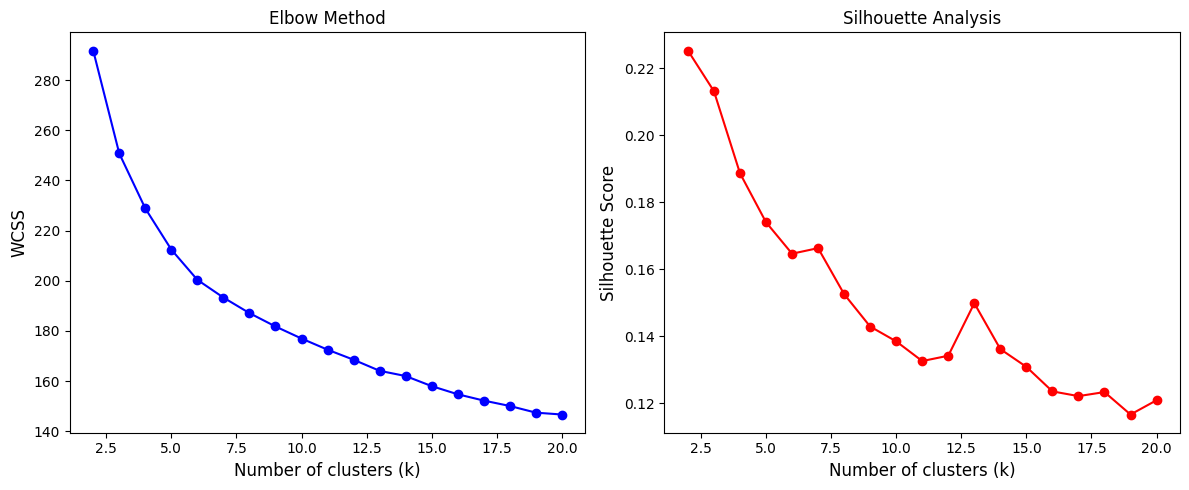

In [ ]:
#Elbow method and silhouette analysis
k_range = range(2, 21)  #testing k from 2-20
wcss = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    clusters = kmeans.fit_predict(spherical_features)

    wcss.append(kmeans.inertia_)
    sil_score = silhouette_score(spherical_features, clusters)
    silhouette_scores.append(sil_score)

#plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, wcss, 'bo-')
ax1.set_xlabel('Number of clusters (k)',fontsize = 12)
ax1.set_ylabel('WCSS', fontsize = 12)
ax1.set_title('Elbow Method')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)',fontsize = 12)
ax2.set_ylabel('Silhouette Score',fontsize = 12)
ax2.set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

k_range = range(2, 21)
metrics_for_thesis = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(spherical_features)

    sil = silhouette_score(spherical_features, labels)
    db = davies_bouldin_score(spherical_features, labels)

    metrics_for_thesis.append({
        'k': k,
        'silhouette': sil,
        'davies_bouldin': db
    })

#identification of best k
best_k_sil = max(metrics_for_thesis, key=lambda x: x['silhouette'])['k']
best_k_db = min(metrics_for_thesis, key=lambda x: x['davies_bouldin'])['k']

print(f"Best k by Silhouette: {best_k_sil}")
print(f"Best k by Davies-Bouldin: {best_k_db}")

Best k by Silhouette: 2
Best k by Davies-Bouldin: 4


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from scipy.stats import entropy

def evaluate_clustering_for_thesis(features, labels, df, k):
    """Function to calculate the cluster validation metrics"""
    results = {}

    #1. Connectivity
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(features)
    distances, indices = nn.kneighbors(features)

    connectivity = 0
    for i, neighbors in enumerate(indices):
        same_cluster = sum(labels[n] == labels[i] for n in neighbors[1:])
        connectivity += same_cluster / (len(neighbors) - 1)
    results['connectivity'] = connectivity / len(features)

    #2. Dunn Index
    from sklearn.metrics.pairwise import pairwise_distances
    unique_labels = np.unique(labels)

    inter_distances = []
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            mask_i = labels == unique_labels[i]
            mask_j = labels == unique_labels[j]
            dist = pairwise_distances(features[mask_i], features[mask_j]).min()
            inter_distances.append(dist)

    intra_distances = []
    for label in unique_labels:
        mask = labels == label
        if mask.sum() > 1:
            cluster_features = features[mask]
            dist = pairwise_distances(cluster_features).max()
            intra_distances.append(dist)

    results['dunn_index'] = min(inter_distances) / max(intra_distances) if inter_distances and intra_distances else 0

    #3. Repo NMI
    repo_labels = pd.Categorical(df['repo']).codes
    results['repo_nmi'] = normalized_mutual_info_score(labels, repo_labels)

    #4. Specification NMI
    spec_labels = df['underspecified'].astype(int).values
    results['spec_nmi'] = normalized_mutual_info_score(labels, spec_labels)

    # 5. Difficulty NMI
    diff_map = {'<15 min fix': 0, '15 min - 1 hour': 1, '1-4 hours': 2, '>4 hours': 3}
    diff_labels = df['difficulty'].map(diff_map).values
    results['diff_nmi'] = normalized_mutual_info_score(labels, diff_labels)


    #5. Stability
    stability_scores = []
    for seed in range(42, 52):  #10 runs
        kmeans_temp = KMeans(n_clusters=k, random_state=seed, n_init=10)
        labels_temp = kmeans_temp.fit_predict(features)
        stability_scores.append(adjusted_rand_score(labels, labels_temp))

    results['stability'] = np.mean(stability_scores)
    results['stability_std'] = np.std(stability_scores)

    return results


results_list = []

for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(spherical_features)
    metrics = evaluate_clustering_for_thesis(spherical_features, labels, df_cleaned, k)

    results_list.append({
        'K': k,
        'Connectivity': f"{metrics['connectivity']:.1%}",
        'Dunn Index': f"{metrics['dunn_index']:.3f}",
        'Specification NMI': f"{metrics['spec_nmi']:.3f}",
        'Difficulty NMI': f"{metrics['diff_nmi']:.3f}",
        'Repository NMI': f"{metrics['repo_nmi']:.3f}",
        'Stability': f"{metrics['stability']:.3f} ± {metrics['stability_std']:.3f}"
    })

#creating df
metrics_df = pd.DataFrame(results_list)
print("\n=== Alternative Clustering Metrics ===")
metrics_df



=== Alternative Clustering Metrics ===


,K,Connectivity,Dunn Index,Specification NMI,Difficulty NMI,Repository NMI,Stability
0,2,93.2%,0.287,0.001,0.119,0.007,0.998 ± 0.004
1,3,92.2%,0.181,0.001,0.138,0.024,1.000 ± 0.000
2,4,90.5%,0.102,0.003,0.109,0.029,0.979 ± 0.035
3,5,88.8%,0.102,0.026,0.172,0.038,0.941 ± 0.034
4,6,88.5%,0.102,0.210,0.164,0.043,0.940 ± 0.029
5,7,87.7%,0.102,0.155,0.265,0.049,0.844 ± 0.109
6,8,86.1%,0.148,0.128,0.252,0.060,0.778 ± 0.116
7,9,83.7%,0.164,0.118,0.216,0.062,0.754 ± 0.089
8,10,83.9%,0.164,0.200,0.226,0.051,0.669 ± 0.070


In [ ]:
#cluster sizes with k=6
spherical_kmeans = KMeans(n_clusters=6, random_state=42, n_init=50)
unified_clusters = spherical_kmeans.fit_predict(spherical_features)

df_cleaned['unified_cluster'] = unified_clusters
print("Cluster distribution:")
print(df_cleaned['unified_cluster'].value_counts().sort_index())

Cluster distribution:
unified_cluster
0     82
1     61
2     78
3     83
4    120
5     76
Name: count, dtype: int64


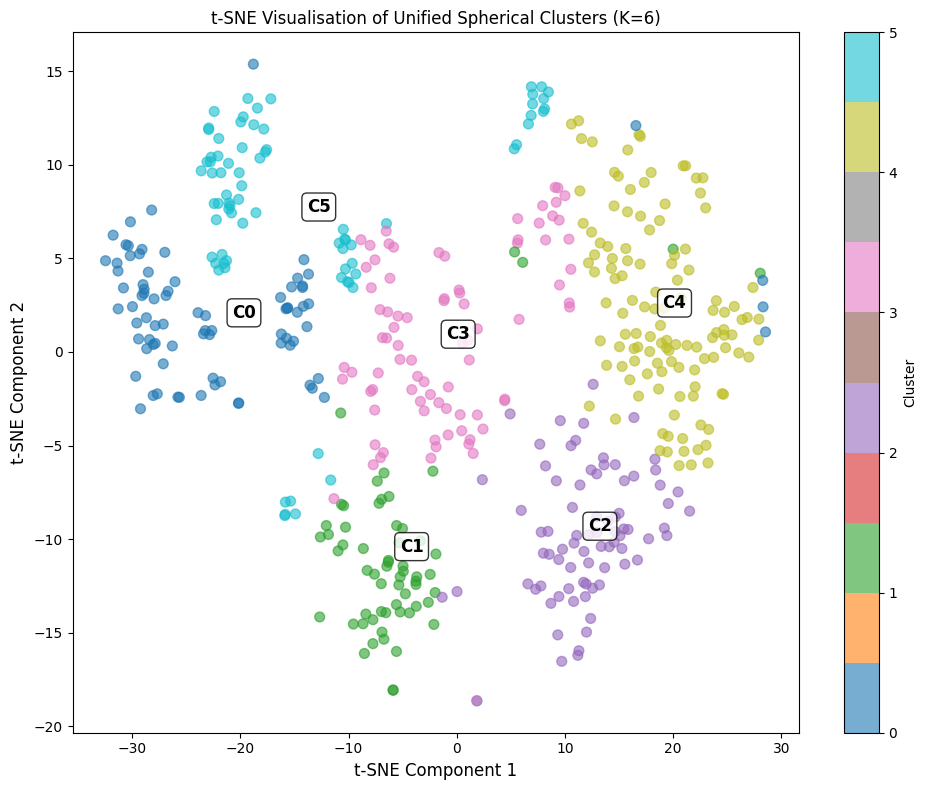

In [ ]:
from sklearn.manifold import TSNE

#creating t-SNE visualisation
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(spherical_features)

#plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                     c=df_cleaned['unified_cluster'],
                     cmap='tab10',
                     alpha=0.6,
                     s=50)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2',fontsize=12)
plt.title('t-SNE Visualisation of Unified Spherical Clusters (K=6)')

#adding cluster centers (approximates)
for i in range(6):
    cluster_points = tsne_results[df_cleaned['unified_cluster'] == i]
    center_x = cluster_points[:, 0].mean()
    center_y = cluster_points[:, 1].mean()
    plt.annotate(f'C{i}', (center_x, center_y),
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
#analysing cluster composition by repos
cluster_repo_dist = pd.crosstab(df_cleaned['repo'], df_cleaned['unified_cluster'])
print("Cluster composition by repository:")
print(cluster_repo_dist)

#checking if clusters align with domains
for cluster in range(6):
    mask = df_cleaned['unified_cluster'] == cluster
    repos = df_cleaned[mask]['repo'].value_counts()
    print(f"\nCluster {cluster} top repositories:")
    print(repos.head())

Cluster composition by repository:
unified_cluster             0   1   2   3   4   5
repo                                             
astropy/astropy             2   1   7   2   5   5
django/django              39  31  29  52  47  33
matplotlib/matplotlib       2   4   2  10  10   6
mwaskom/seaborn             0   1   0   0   1   0
pallets/flask               0   1   0   0   0   0
psf/requests                1   1   0   1   1   4
pydata/xarray               5   2   6   3   4   2
pylint-dev/pylint           1   2   1   0   4   2
pytest-dev/pytest           2   2   5   0   6   4
scikit-learn/scikit-learn   5   5   4   6  10   2
sphinx-doc/sphinx          10   2  13   2  11   6
sympy/sympy                15   9  11   7  21  12

Cluster 0 top repositories:
repo
django/django                39
sympy/sympy                  15
sphinx-doc/sphinx            10
pydata/xarray                 5
scikit-learn/scikit-learn     5
Name: count, dtype: int64

Cluster 1 top repositories:
repo
django/djan

In [ ]:
def create_cluster_summary_table(df):
    """function creates summary table using mean values"""
    results = []

    for cluster_num in range(6):
        subset = df[df['unified_cluster'] == cluster_num]

        results.append({
            'Cluster': cluster_num,
            'Size': len(subset),
            'Files': subset['num_files'].mean(),
            'Hunks': subset['num_hunks'].mean(),
            'Total_lines': subset['total_lines_changed'].mean(),
            'Change_ratio': subset['change_ratio'].mean(),
            'Max_file': subset['max_file_change'].mean(),
            'Change_conc': subset['change_concentration'].mean(),
            'Underspec_%': subset['underspecified'].mean() * 100,
        })

    return pd.DataFrame(results)

summary_table = create_cluster_summary_table(df_cleaned)
summary_table

,Cluster,Size,Files,Hunks,Total_lines,Change_ratio,Max_file,Change_conc,Underspec_%
0,0,82,1.036585,1.048780,2.621951,0.587184,2.536585,0.673868,0.000000
1,1,61,1.049180,1.278689,7.786885,1.884393,7.672131,0.848818,44.262295
2,2,78,1.282051,2.705128,39.858974,0.991898,36.115385,0.910460,51.282051
3,3,83,1.012048,1.240964,6.542169,0.902079,6.493976,0.838776,81.927711
4,4,120,1.783333,5.450000,21.733333,0.922935,17.433333,0.799340,42.500000
5,5,76,1.000000,1.157895,2.855263,0.538089,2.855263,0.703321,100.000000


In [ ]:
def create_difficulty_distribution_table(df):
    """Function to create a table showing difficulty distribution across clusters"""

    difficulty_order = ['<15 min fix', '15 min - 1 hour', '1-4 hours', '>4 hours']
    results = []

    for cluster_num in range(6):
        subset = df[df['unified_cluster'] == cluster_num]
        difficulty_counts = subset['difficulty'].value_counts()

        row = {'Cluster': cluster_num, 'Size': len(subset)}
        #adding counts and percentages
        for difficulty_level in difficulty_order:
            count = difficulty_counts.get(difficulty_level, 0)
            percentage = (count / len(subset)) * 100 if len(subset) > 0 else 0
            row[difficulty_level] = f"{count} ({percentage:.0f}%)"

        #adding primary difficulty
        row['Primary'] = difficulty_counts.index[0] if len(difficulty_counts) > 0 else "N/A"
        results.append(row)

    diff_df = pd.DataFrame(results)

    #formatted table
    print("\nDifficulty Distribution Across Clusters")
    print("="*120)
    print(f"{'Cluster':<8} {'Size':<6} {'<15 min':<15} {'15min-1h':<15} {'1-4h':<15} {'>4h':<15} {'Primary':<20}")
    print("-"*120)

    for _, row in diff_df.iterrows():
        print(f"{row['Cluster']:<8} {row['Size']:<6} {row['<15 min fix']:<15} {row['15 min - 1 hour']:<15} "
              f"{row['1-4 hours']:<15} {row['>4 hours']:<15} {row['Primary']:<20}")

    return diff_df

difficulty_table = create_difficulty_distribution_table(df_cleaned)


Difficulty Distribution Across Clusters
Cluster  Size   <15 min         15min-1h        1-4h            >4h             Primary             
------------------------------------------------------------------------------------------------------------------------
0        82     56 (68%)        26 (32%)        0 (0%)          0 (0%)          <15 min fix         
1        61     32 (52%)        28 (46%)        1 (2%)          0 (0%)          <15 min fix         
2        78     10 (13%)        48 (62%)        19 (24%)        1 (1%)          15 min - 1 hour     
3        83     2 (2%)          74 (89%)        7 (8%)          0 (0%)          15 min - 1 hour     
4        120    32 (27%)        71 (59%)        15 (12%)        2 (2%)          15 min - 1 hour     
5        76     62 (82%)        14 (18%)        0 (0%)          0 (0%)          <15 min fix         


In [ ]:
def extract_cluster_examples_for_table(df, cluster_num):
    """This function extracts full problem details for manual selection"""
    subset = df[df['unified_cluster'] == cluster_num]

    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_num} - Full Examples")
    print(f"{'='*80}")

    #getting representative examples from different difficulty levels
    difficulty_counts = subset['difficulty'].value_counts()

    for difficulty, count in difficulty_counts.items():
        pct = count/len(subset)*100
        if pct < 15:  #skipping very minor categories
            continue

        print(f"\n--- {difficulty} ({count} tasks, {pct:.0f}%) ---")

        difficulty_data = subset[subset['difficulty'] == difficulty]
        samples = difficulty_data.sample(n=min(5, len(difficulty_data)), random_state=42)  #getting up to 5 examples

        for i, (idx, row) in enumerate(samples.iterrows(), 1):
            spec_status = "UNDERSPECIFIED" if row['underspecified'] else "WELL-SPECIFIED"
            print(f"\n{i}. [{spec_status}] {row['repo']}")
            print(f"   Lines changed: {int(row['total_lines_changed'])}")
            print(f"   Problem: {row['problem_statement']}")
            print("-" * 40)

#examples for all clusters
for cluster_num in range(6):
    extract_cluster_examples_for_table(df_cleaned, cluster_num)


CLUSTER 0 - Full Examples

--- <15 min fix (56 tasks, 68%) ---

1. [WELL-SPECIFIED] astropy/astropy
   Lines changed: 4
   Problem: In v5.3, NDDataRef mask propagation fails when one of the operand does not have a mask
### Description

This applies to v5.3. 

It looks like when one of the operand does not have a mask, the mask propagation when doing arithmetic, in particular with `handle_mask=np.bitwise_or` fails.  This is not a problem in v5.2.

I don't know enough about how all that works, but it seems from the error that the operand without a mask is set as a mask of None's and then the bitwise_or tries to operate on an integer and a None and fails.

### Expected behavior

When one of the operand does not have mask, the mask that exists should just be copied over to the output.  Or whatever was done in that situation in v5.2 where there's no problem.

### How to Reproduce

This is with v5.3.   With v5.2, there are no errors.

```
>>> import numpy as np
>>> from astropy.nddata impor

## BERT ONLY Clusters

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

BERT-only embeddings shape: (500, 384)
k=2: Silhouette=0.0752, WCSS=368.18
k=3: Silhouette=0.0717, WCSS=353.44
k=4: Silhouette=0.0704, WCSS=343.54
k=5: Silhouette=0.0751, WCSS=335.91
k=6: Silhouette=0.0633, WCSS=328.50
k=7: Silhouette=0.0596, WCSS=322.44
k=8: Silhouette=0.0663, WCSS=316.63
k=9: Silhouette=0.0593, WCSS=311.95
k=10: Silhouette=0.0620, WCSS=307.77
k=11: Silhouette=0.0655, WCSS=303.94
k=12: Silhouette=0.0686, WCSS=300.56
k=13: Silhouette=0.0635, WCSS=297.72
k=14: Silhouette=0.0633, WCSS=294.99
k=15: Silhouette=0.0640, WCSS=292.91
k=16: Silhouette=0.0605, WCSS=290.79
k=17: Silhouette=0.0578, WCSS=288.99
k=18: Silhouette=0.0589, WCSS=287.24
k=19: Silhouette=0.0619, WCSS=285.99
k=20: Silhouette=0.0600, WCSS=283.40


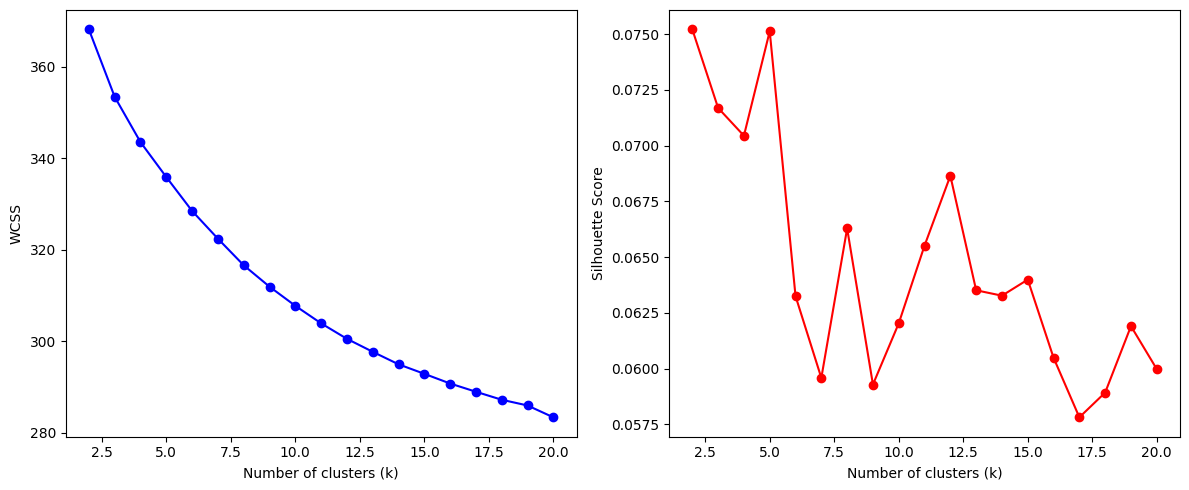


=== Checking BERT-only Specification NMI ===
k=2: Specification NMI = 0.003
k=3: Specification NMI = 0.003
k=4: Specification NMI = 0.003
k=5: Specification NMI = 0.004
k=6: Specification NMI = 0.006
k=7: Specification NMI = 0.007
k=8: Specification NMI = 0.006
k=9: Specification NMI = 0.005
k=10: Specification NMI = 0.008


In [ ]:
#Extracting just BERT embeddings with repo context

#repos context mapping (same as before)
repo_context = {
    'astropy/astropy': 'astronomy scientific computing',
    'django/django': 'web framework backend',
    'matplotlib/matplotlib': 'data visualization plotting',
    'mwaskom/seaborn': 'statistical visualization',
    'pallets/flask': 'web microframework',
    'psf/requests': 'HTTP library networking',
    'pydata/xarray': 'multidimensional arrays',
    'pylint-dev/pylint': 'code analysis linting',
    'pytest-dev/pytest': 'testing framework',
    'scikit-learn/scikit-learn': 'machine learning',
    'sphinx-doc/sphinx': 'documentation generator',
    'sympy/sympy': 'symbolic mathematics'
}

#creating domain-aware problem statements
df['repo_context'] = df['repo'].map(repo_context).fillna(df['repo'].str.split('/').str[-1])
problem_statements = ('[' + df['repo_context'] + '] ' + df['problem_statement'].fillna('')).tolist()

#embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
bert_only_embeddings = model.encode(df_cleaned['domain_aware_statement'].tolist(), show_progress_bar=True)

#normalising for spherical clustering
bert_spherical = normalize(bert_only_embeddings, norm='l2')

print(f"BERT-only embeddings shape: {bert_spherical.shape}")

#testing different k values
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_range = range(2, 21)
silhouette_scores = []
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(bert_spherical)

    sil_score = silhouette_score(bert_spherical, labels)
    silhouette_scores.append(sil_score)
    wcss.append(kmeans.inertia_)

    print(f"k={k}: Silhouette={sil_score:.4f}, WCSS={kmeans.inertia_:.2f}")

#results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, wcss, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('WCSS')
#ax1.set_title('Elbow Method - BERT Only')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
#ax2.set_title('Silhouette Analysis - BERT Only')

plt.tight_layout()
plt.show()

#checking specification NMI for key k values
print("\n=== Checking BERT-only Specification NMI ===")
for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(bert_spherical)

    spec_nmi = normalized_mutual_info_score(labels, df_cleaned['underspecified'].astype(int))
    print(f"k={k}: Specification NMI = {spec_nmi:.3f}")

In [ ]:
#checking if BERT clusters align with repositories instead
from sklearn.metrics import normalized_mutual_info_score

print("=== BERT-only Repository Alignment ===")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(bert_spherical)

    #repo labels
    repo_labels = pd.Categorical(df_cleaned['repo']).codes

    repo_nmi = normalized_mutual_info_score(labels, repo_labels)
    print(f"k={k}: Repository NMI = {repo_nmi:.3f}")

#check average pairwise similarity
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(bert_spherical)
avg_similarity = (similarities.sum() - len(similarities)) / (len(similarities) * (len(similarities) - 1))
print(f"\nAverage pairwise cosine similarity: {avg_similarity:.3f}")

=== BERT-only Repository Alignment ===
k=2: Repository NMI = 0.543
k=3: Repository NMI = 0.591
k=4: Repository NMI = 0.704
k=5: Repository NMI = 0.759
k=6: Repository NMI = 0.766
k=7: Repository NMI = 0.764
k=8: Repository NMI = 0.820
k=9: Repository NMI = 0.760
k=10: Repository NMI = 0.766

Average pairwise cosine similarity: 0.199


In [ ]:
#checking repos alignment for full k=6 clustering
repo_labels = pd.Categorical(df_cleaned['repo']).codes
repo_nmi_full = normalized_mutual_info_score(df_cleaned['unified_cluster'], repo_labels)
print(f"Full model (k=6) Repository NMI: {repo_nmi_full:.3f}")

#cross-tab
repo_dist = pd.crosstab(df_cleaned['repo'], df_cleaned['unified_cluster'], normalize='columns')
print("\nRepository distribution across clusters (column %):")
print(repo_dist.round(2))

Full model (k=6) Repository NMI: 0.043

Repository distribution across clusters (column %):
unified_cluster               0     1     2     3     4     5
repo                                                         
astropy/astropy            0.02  0.02  0.09  0.02  0.04  0.07
django/django              0.48  0.51  0.37  0.63  0.39  0.43
matplotlib/matplotlib      0.02  0.07  0.03  0.12  0.08  0.08
mwaskom/seaborn            0.00  0.02  0.00  0.00  0.01  0.00
pallets/flask              0.00  0.02  0.00  0.00  0.00  0.00
psf/requests               0.01  0.02  0.00  0.01  0.01  0.05
pydata/xarray              0.06  0.03  0.08  0.04  0.03  0.03
pylint-dev/pylint          0.01  0.03  0.01  0.00  0.03  0.03
pytest-dev/pytest          0.02  0.03  0.06  0.00  0.05  0.05
scikit-learn/scikit-learn  0.06  0.08  0.05  0.07  0.08  0.03
sphinx-doc/sphinx          0.12  0.03  0.17  0.02  0.09  0.08
sympy/sympy                0.18  0.15  0.14  0.08  0.18  0.16
